Import necessary libraries

In [1]:
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model
from keras.preprocessing import image
from matplotlib import pyplot as plt
import numpy as np
import os
import copy
import cv2
from scipy.ndimage import zoom
import imutils

Load the VGG16 model, imagenet is the default weight

In [2]:
model       = VGG16()
totalLayers = len(model.layers)

553467904/553467096 [==============================] - 3s 0us/step


In [3]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Load the test image

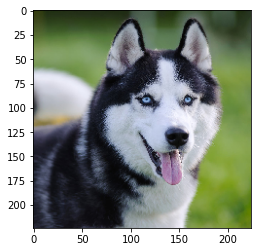

In [4]:
fileNames = ['husky.jpg','cat.jpg','lawn_mower.jpg','airplane.jpg']
path      = os.path.join(os.getcwd(), 'drive/My Drive/NEU/7150/Final Project/Image/')

imgPaths  = []
orgImages = []
cv2Images = []

for fileName in fileNames:
  imgPaths.append(path + fileName)

# load the images with the size expected by the model, in this case, 224×224
for imgPath in imgPaths:
  orgImages.append(image.load_img(imgPath, target_size=(224, 224)))

for item in imgPaths:
  cv2Img = cv2.imread(item)
  cv2Img = cv2.resize(cv2Img, (224,224))
  cv2Images.append(cv2Img)

img       = copy.deepcopy(orgImages[0])
plt.imshow(img)

# the image PIL object needs to be converted to a NumPy array of pixel data and 
# expanded from a 3D array to a 4D array with the dimensions of 
# [samples, rows, cols, channels], where we only have one sample
def preProcessInput(item, flag = False):
  processedImg = copy.deepcopy(item)
  processedImg = image.img_to_array(processedImg)
  # expand dimensions so that it represents a single 'sample'
  processedImg = np.expand_dims(processedImg, axis=0)
  # prepare the image (e.g. scale pixel values for the vgg)
  if flag == False:
    processedImg = preprocess_input(processedImg)

  return processedImg

img = preProcessInput(img)

The below function displays the maximum and mean activation from each layer for the given test image

In [5]:
def displayMaxMeanActivationsOfAllLayers(trainedModel, testImage):
  noOfLayers  = len(trainedModel.layers)
  imgIndex    = 1
  fig         = plt.figure(figsize=(20, 60))

  for layerIndex in range(noOfLayers):
    layer = trainedModel.layers[layerIndex]

    if 'conv' not in layer.name:
      continue
    
    # print(layerIndex, layer.name, layer.output.shape)

    layerModel  = Model(inputs=trainedModel.inputs, outputs=trainedModel.layers[layerIndex].output)
    features    = layerModel.predict(testImage)

    numberOfFeatures = len(features[0,0,0,:])

    maxActivationIndex  = None
    maxNorm             = None

    for i in range(1,numberOfFeatures):
      currNorm = np.linalg.norm(features[0,:,:,i])
      if maxNorm is None or currNorm > maxNorm:
        maxNorm             = currNorm
        maxActivationIndex  = i

    maxActivation = features[0,:,:,maxActivationIndex]
    axs1          = fig.add_subplot((int)(np.ceil(noOfLayers/2)), 4, imgIndex)
    axs1.set_title('Max Activation of ' + layer.name)
    plt.imshow(maxActivation, cmap='viridis')
    plt.colorbar()
    imgIndex      = imgIndex + 1

    mean = None
    for i in range(numberOfFeatures):
      if mean is None:
        mean = copy.deepcopy(features[0,:,:,i])
      else:
        mean += features[0,:,:,i]

    mean      = mean/numberOfFeatures
    axs2      = fig.add_subplot((int)(np.ceil(noOfLayers/2)), 4, imgIndex)
    axs2.set_title('Mean Activation of ' + layer.name)
    plt.imshow(mean, cmap='viridis')
    plt.colorbar()
    imgIndex  = imgIndex + 1

  plt.show()

The below function displays the max activation of each image for all layers

In [6]:
def displayMaxActivationsOfAllLayers(trainedModel, testImages):
  noOfLayers  = len(trainedModel.layers)
  imgIndex    = 1

  for layerIndex in range(noOfLayers):
    layer = trainedModel.layers[layerIndex]

    if 'conv' not in layer.name:
      continue
    
    # print(layerIndex, layer.name, layer.output.shape)
    layerModel      = Model(inputs=trainedModel.inputs, outputs=trainedModel.layers[layerIndex].output)
    maxActivations  = []

    for testImage in testImages:
      features            = layerModel.predict(testImage)
      numberOfFeatures    = len(features[0,0,0,:])
      maxActivationIndex  = None
      maxNorm             = None

      for i in range(1,numberOfFeatures):
        currNorm = np.linalg.norm(features[0,:,:,i])
        if maxNorm is None or currNorm > maxNorm:
          maxNorm             = currNorm
          maxActivationIndex  = i

      maxActivation = features[0,:,:,maxActivationIndex]
      maxActivations.append(maxActivation)

    cols  = 3
    rows  = 3
    fig   = plt.figure(figsize=(cols,rows))

    for index in range(0,9):
      currImage = maxActivations[index]
      fig.add_subplot(rows, cols, index+1)
      plt.axis('off')
      plt.imshow(currImage)
    
    plt.suptitle(layer.name)
    plt.show()

In [7]:
def displayAllFeaturesOfALayer(trainedModel, testImage, layerIndex):
  noOfLayers  = len(trainedModel.layers)

  if layerIndex >= noOfLayers:
    print('Invalid layer index')
    return
  
  layer = trainedModel.layers[layerIndex]

  if 'conv' not in layer.name:
    print('Not a convolutional layer')
    return
  
  layerModel        = Model(inputs=trainedModel.inputs, outputs=trainedModel.layers[layerIndex].output)
  features          = layerModel.predict(testImage)
  features          = features[0]
  numberOfFeatures  = len(features[0,0,:])

  cols = 16
  rows = int(np.ceil(numberOfFeatures/cols))

  fig  = plt.figure(figsize=(cols,rows))

  for index in range(numberOfFeatures):
    currImage = features[:,:,index]
    fig.add_subplot(rows, cols, index+1)
    plt.axis('off')
    plt.imshow(currImage)

  plt.show()

Prepare the test images

In [8]:
dogFileNames = ['dog_face_1.jpg','dog_face_2.jpg','dog_face_3.jpg','dog_face_4.jpg','dog_face_5.jpg','dog_face_6.jpg','dog_face_7.jpg','dog_face_8.jpg','dog_face_9.jpg']

dogImgPaths  = []
dogOrgImages = []

for fileName in dogFileNames:
  dogImgPaths.append(path + fileName)

# load the images with the size expected by the model, in this case, 224×224
for imgPath in dogImgPaths:
  cv2Img = cv2.imread(imgPath)
  cv2Img = cv2.resize(cv2Img, (224,224))
  cv2Img = np.expand_dims(cv2Img, axis = 0)
  dogOrgImages.append(cv2Img)
  #dogOrgImages.append(image.load_img(imgPath, target_size=(224, 224)))

In [9]:
wheelFileNames = ['car_wheel_1.jpg','car_wheel_2.jpg','car_wheel_3.jpg','car_wheel_4.jpg','car_wheel_5.jpg','car_wheel_6.jpg','car_wheel_7.jpg','car_wheel_8.jpg','car_wheel_9.jpg']

wheelImgPaths  = []
wheelOrgImages = []

for fileName in wheelFileNames:
  wheelImgPaths.append(path + fileName)

# load the images with the size expected by the model, in this case, 224×224
for imgPath in wheelImgPaths:
  wheelOrgImages.append(image.load_img(imgPath, target_size=(224, 224)))

The dog set

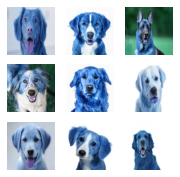

In [10]:
figure   = plt.figure(figsize=(3,3))

for index in range(0,9):
  currImage = (dogOrgImages[index])
  figure.add_subplot(3, 3, index+1)
  plt.axis('off')
  plt.imshow(currImage[0])

plt.show()

Display maximum activations of dog set

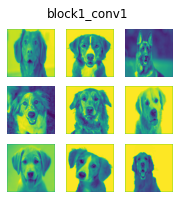

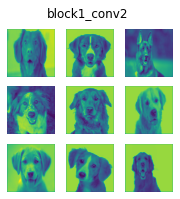

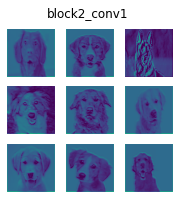

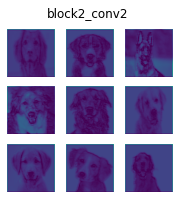

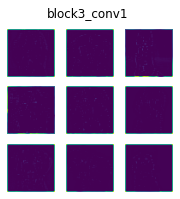

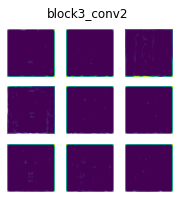

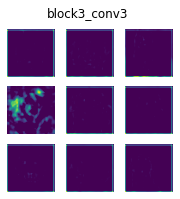

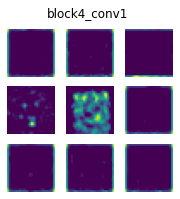

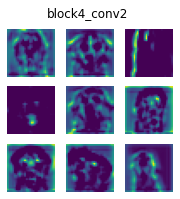

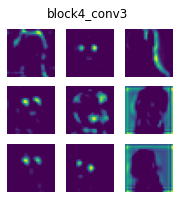

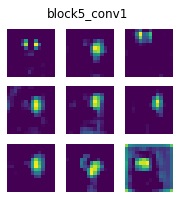

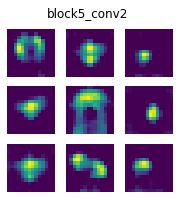

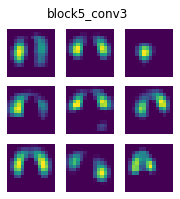

In [11]:
displayMaxActivationsOfAllLayers(model, dogOrgImages)

The wheel set

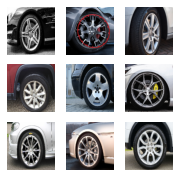

In [12]:
figure   = plt.figure(figsize=(3,3))

for index in range(0,9):
  currImage = (wheelOrgImages[index])
  figure.add_subplot(3, 3, index+1)
  plt.axis('off')
  plt.imshow(currImage)

plt.show()

Display maximum activations of wheel set

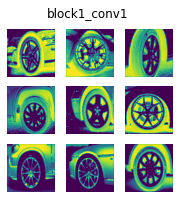

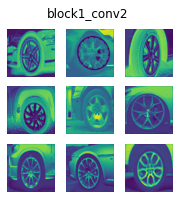

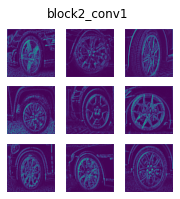

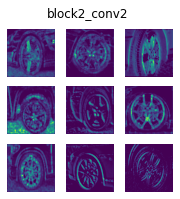

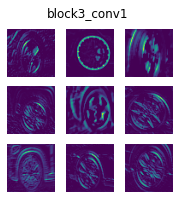

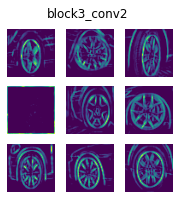

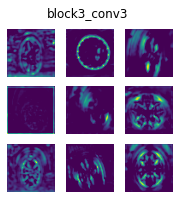

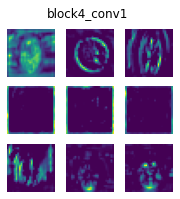

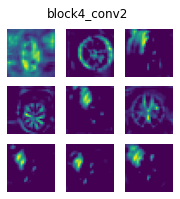

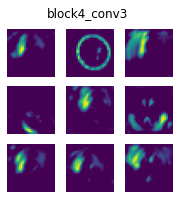

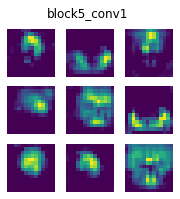

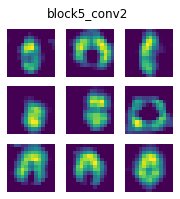

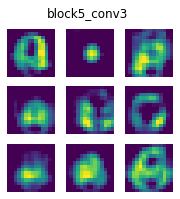

In [13]:
wheels = []

for item in wheelOrgImages:
  wheels.append(preProcessInput(item))

displayMaxActivationsOfAllLayers(model, wheels)

Utility functions to plot graph against accuracy and euclidean distance

In [14]:
def getAccuracyVariation(trainedModel, x_test, x_axis, x_label, legends, orgImageIndex = 0):
  fig=plt.figure(figsize=(5, 5))

  for index, item in enumerate(x_test):
    y_pred  = trainedModel.predict(item)
    y_acc   = []

    classId = np.argmax(y_pred[orgImageIndex])

    for pred in y_pred:
      y_acc.append(pred[classId])

    plt.plot(x_axis, y_acc, label=legends[index])

  plt.xlabel(x_label)
  plt.ylabel('Accuracy')
  plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

In [15]:
def getEuclideanDistanceVariation(trainedModel, x_test, x_axis, x_label, layerIndex, legends, orgImageIndex = 0):
  fig=plt.figure(figsize=(5, 5))

  layer = trainedModel.layers[layerIndex]
  if 'conv' not in layer.name:
    print('Not a convolutional layer.')
    return

  for i, item in enumerate(x_test):
    layerModel  = Model(inputs=trainedModel.inputs, outputs=trainedModel.layers[layerIndex].output)
    features    = layerModel.predict(item)

    originalFeatures  = features[orgImageIndex]
    eucDist           = []

    for index in range(0, len(features)):
      dist = np.linalg.norm(originalFeatures - features[index])
      eucDist.append(dist)
    
    plt.plot(x_axis, eucDist, label = legends[i])

  plt.title(layer.name)
  plt.xlabel(x_label)
  plt.ylabel('Euclidean distance')
  plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

In [16]:
def drawTestImageDataSet(dataSet):
  for testImageDataSet in dataSet:
    totalImages = len(testImageDataSet[:,0,0,0])

    cols        = 8
    rows        = 1

    figure      = plt.figure(figsize=(cols, rows))

    index       = 0
    increment   = int(np.floor(totalImages/9))
    counter     = 1

    while counter <= 8:
      currImage = testImageDataSet[index,:,:,:]
      figure.add_subplot(rows,cols,counter)
      plt.axis('off')
      plt.imshow(currImage)
      index += increment
      counter += 1

Build dataset to analyze rotational variance

In [17]:
def buildRotatedDataSet(orgImg, flag = False):
  rotatedImages = []
  degree        = 0
  x_rot         = []

  while degree <= 360:
    x_rot.append(degree)
    processedImg = None
    if flag == False:
      processedImg = preProcessInput(orgImg.rotate(degree))
      rotatedImages.append(processedImg[0])
    else:
      processedImg = imutils.rotate(orgImg, degree)
      rotatedImages.append(processedImg)
    degree += 5

  rotatedImages = np.array(rotatedImages)

  return (rotatedImages, x_rot)

rotatedDataSet = []
x_rot          = []

# for item in orgImages:
#   data , x  = buildRotatedDataSet(item)
#   x_rot     = x
#   rotatedDataSet.append(data)

for item in cv2Images:
  data , x = buildRotatedDataSet(item, True)
  x_rot = x
  rotatedDataSet.append(data)

The rotated dataset

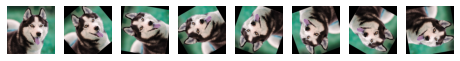

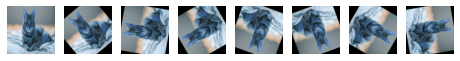

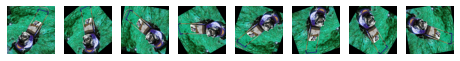

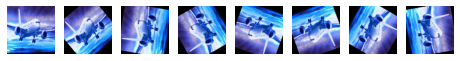

In [18]:
drawTestImageDataSet(rotatedDataSet)

The results for rotated dataset

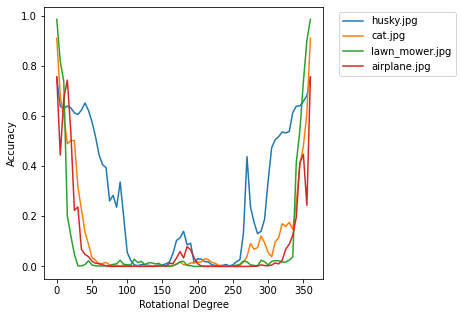

In [19]:
getAccuracyVariation(model, rotatedDataSet, x_rot, 'Rotational Degree', fileNames)

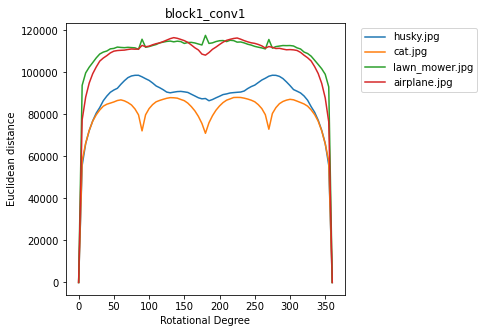

In [20]:
getEuclideanDistanceVariation(model, rotatedDataSet, x_rot, 'Rotational Degree', 1, fileNames)

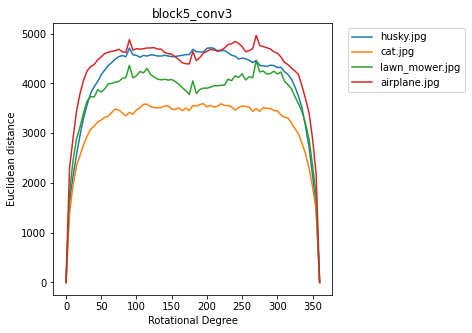

In [21]:
getEuclideanDistanceVariation(model, rotatedDataSet, x_rot, 'Rotational Degree', 17, fileNames)

Build dataset to analyze the effect of scaling

In [22]:
def buildScaledDataset(images, flag = False):
  finalDataset  = []
  scales        = [32,16,14,12,11,10,9,8,7,6.5,6,5.5,5.3,5,4.8,4.5,4.4,4.3,4.2,4.1,4]
  x_scale       = []
  for item in images:
    x           = [1]
    data        = []
    imgToScale  = item
    data.append(imgToScale)

    for scale in scales:
      imgToScale  = item
      lx, ly, lz  = imgToScale.shape
      xValue      = (int)(np.floor(lx/scale))
      yValue      = (int)(np.floor(ly/scale))
      crop_img    = imgToScale[xValue:-xValue, yValue:-yValue,:]
      lx, ly, lz  = crop_img.shape
      x.append(224/lx)
      crop_img    = cv2.resize(crop_img,None,fx=224/lx,fy=224/ly)
      data.append(crop_img)
    
    data    = np.array(data)
    finalDataset.append(data)
    x_scale = x

  return (finalDataset,x)



scaledDataSet, x_scale = buildScaledDataset(cv2Images)

The scaled dataset

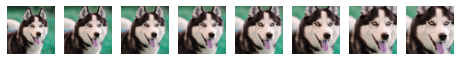

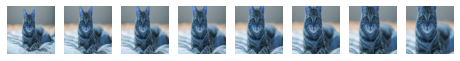

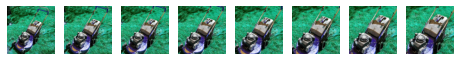

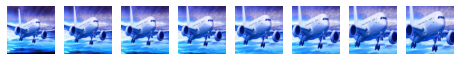

In [23]:
drawTestImageDataSet(scaledDataSet)

The results for scaled dataset

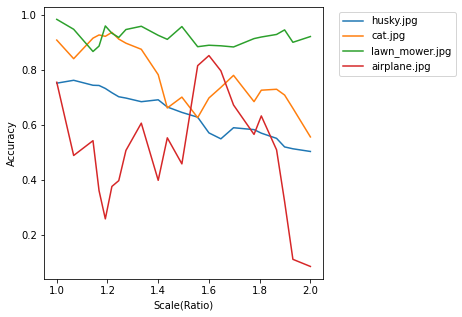

In [24]:
getAccuracyVariation(model, scaledDataSet, x_scale, 'Scale(Ratio)', fileNames)

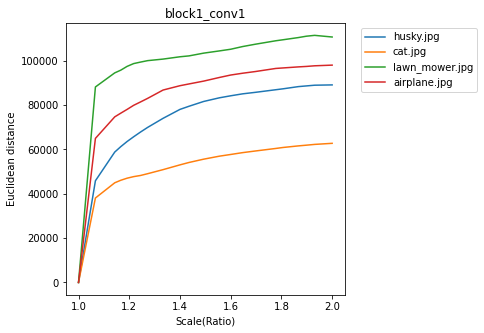

In [25]:
getEuclideanDistanceVariation(model, scaledDataSet, x_scale, 'Scale(Ratio)', 1, fileNames)

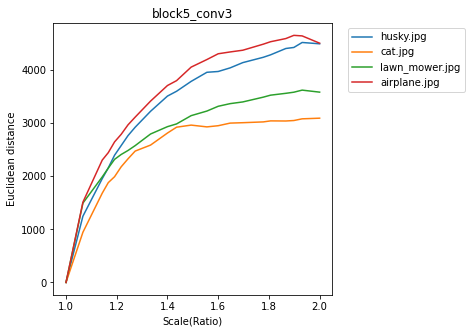

In [26]:
getEuclideanDistanceVariation(model, scaledDataSet, x_scale, 'Scale(Ratio)', 17, fileNames)

Build the dataset to analyze the effect of vertical translation

In [27]:
def getTranslatedSet(orgImg, yTranslations, flag = False):
  translatedSet = []
  img           = orgImg

  num_rows, num_cols, num_colors  = img.shape

  for yt in yTranslations:
    translation_matrix  = np.float32([[1,0,0],[0,1,yt]])
    img_translation     = cv2.warpAffine(img, translation_matrix, (num_cols, num_rows))
    translatedSet.append(img_translation)
  
  translatedSet = np.array(translatedSet)

  return translatedSet

translatedDataSet = []
yTs               = []
counter           = -60
while counter <= 60:
  yTs.append(counter)
  counter += 1

totalYts = len(yTs)

#for item in orgImages:
#  translatedDataSet.append(getTranslatedSet(item,yTs))

for item in cv2Images:
  translatedDataSet.append(getTranslatedSet(item, yTs))

The vertically translated dataset

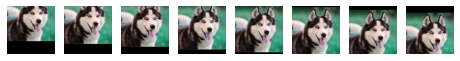

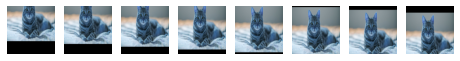

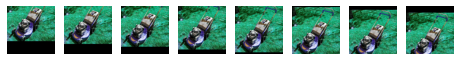

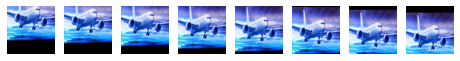

In [28]:
drawTestImageDataSet(translatedDataSet)

The results for the vertically translated dataset

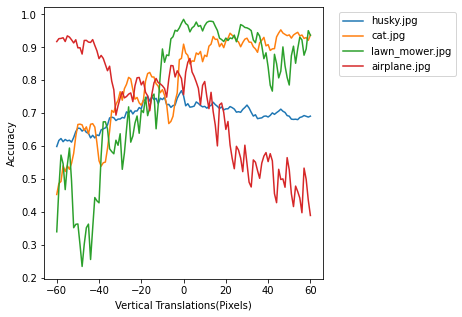

In [29]:
getAccuracyVariation(model, translatedDataSet, yTs, 'Vertical Translations(Pixels)', fileNames, totalYts//2)

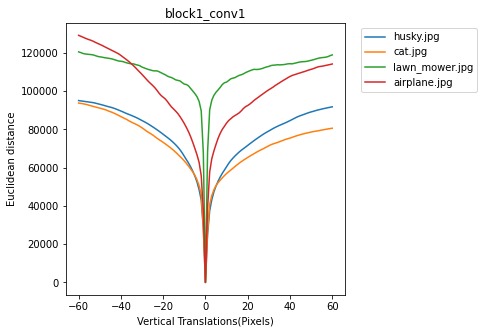

In [30]:
getEuclideanDistanceVariation(model, translatedDataSet, yTs, 'Vertical Translations(Pixels)', 1, fileNames, totalYts//2)

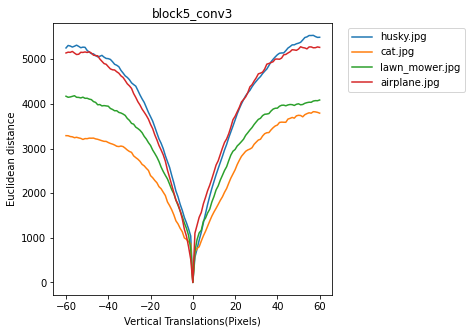

In [31]:
getEuclideanDistanceVariation(model, translatedDataSet, yTs, 'Vertical Translations(Pixels)', 17, fileNames, totalYts//2)